In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

# Dataset: fNIRS Brain Imaging

Functional near-infrared spectroscopy (fNIRS) contains brain imaginary data recorded at $690nm$ intensity. There are $208.028$ measurements in total. The data is known to be a difficult example, as it contains four motion artifacts, due to movements of the patient, which dominate MD.

## References:
- [1] https://dl.acm.org/doi/pdf/10.1145/3097983.3097993

Dataset Original Length n:  10401
Dataset Sampled Length n:  10401


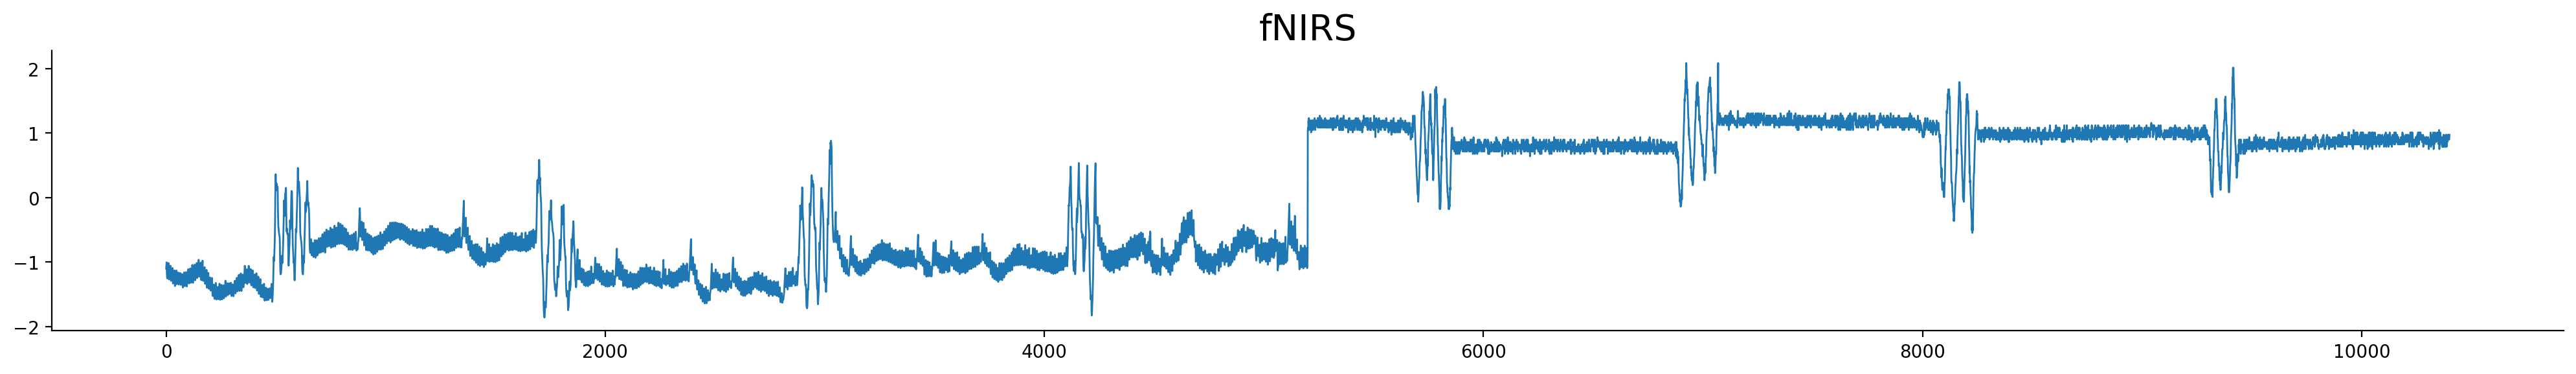

(<Figure size 2000x300 with 1 Axes>, [<Axes: title={'center': 'fNIRS'}>])

In [2]:
file = "fNIRS_subLen_600.csv" 
ds_name = "fNIRS"
series = ml.read_dataset_with_index(file)
data = series.values
plot_dataset(ds_name, series)

# Known Motifs

A "significant medical" motif was reported in [1], but without specifying its length.

[1] Dau, Hoang Anh, and Eamonn Keogh. "Matrix profile v: A generic technique to incorporate domain knowledge into motif discovery." Proceedings of the 23rd ACM SIGKDD international conference on knowledge discovery and data mining. 2017.
    

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
ks = 20
dataset = os.getcwd() + '/../datasets/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets_paper/notebooks/../datasets/fNIRS_subLen_600.csv


# k-Motiflets

## First, we learn the motif length l

We find a minimum around 140 data points.

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

	Time 1.0 s


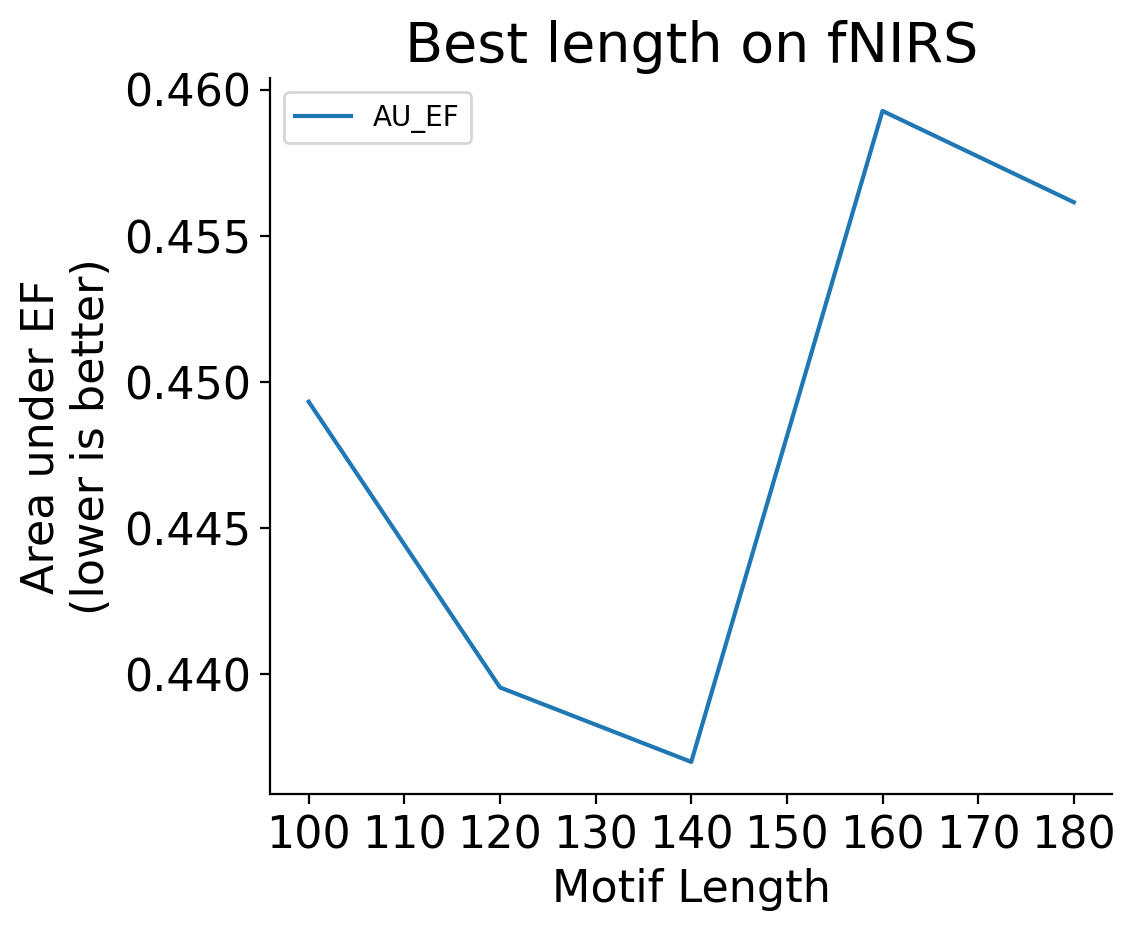

Found motif length 140


In [4]:
length_range = np.arange(100,200,20) 
motif_length = plot_motif_length_selection(
    ks, series, length_range, ds_name)
print ("Found motif length", series.index[motif_length])

## We learn the size k of the motif set

We plot the similarity of the motifs as a function of the cardinality of $k$-Motiflets to their extent. Elbow points represent large changes in similarity of the found motif set, indicative of a concept change from calibrations signal to heartbeats.


Data 10401


Compute ks (20):   0%|          | 0/18 [00:00<?, ?it/s]

Chosen window-size: 140 in 0.6 s
Elbow Points [ 4 18]


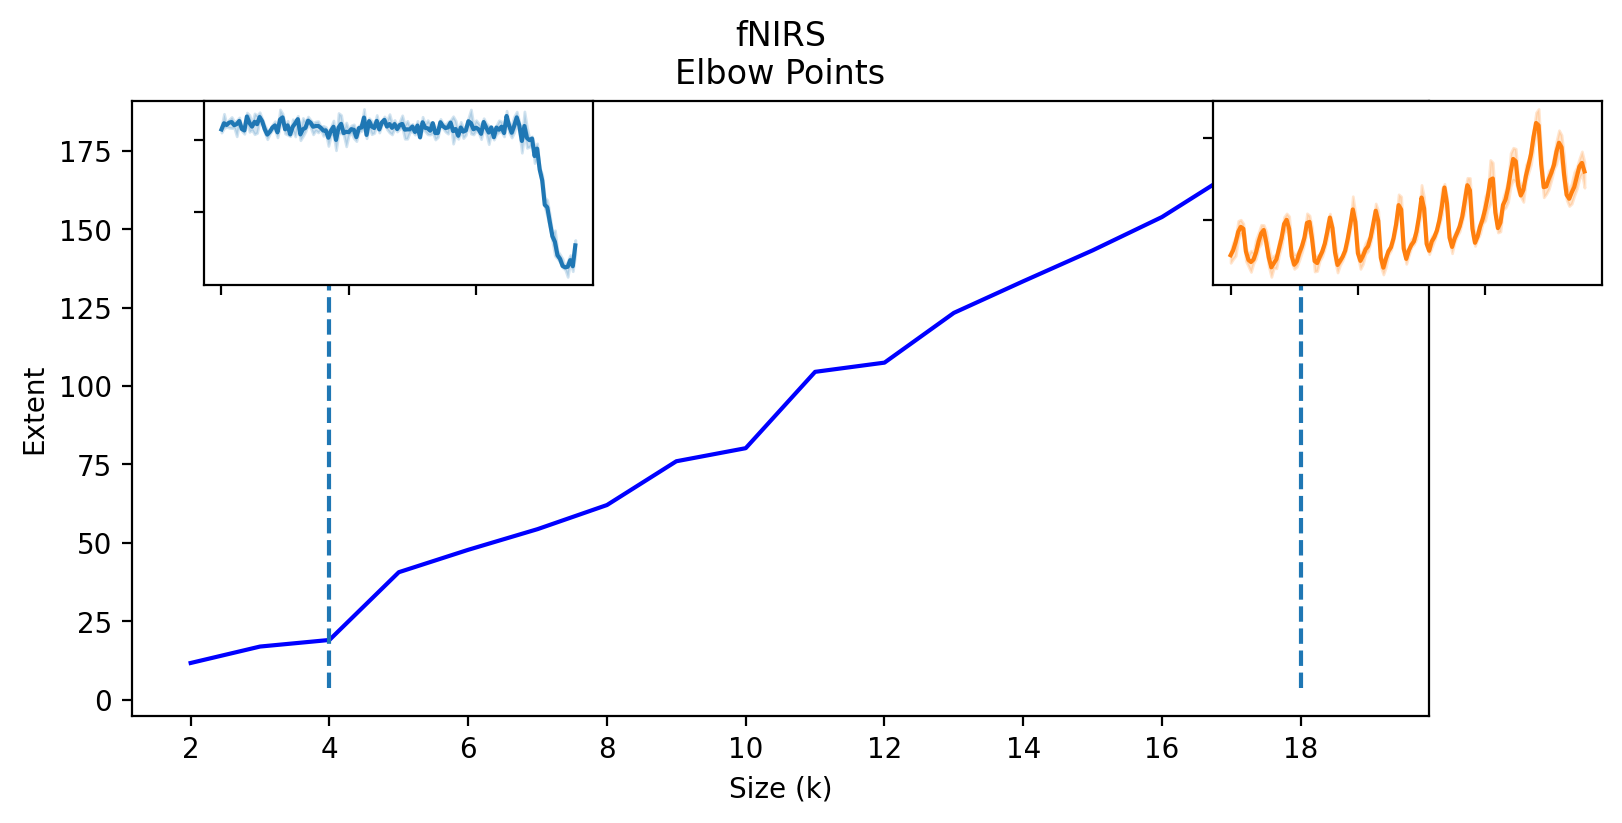

Data 10401


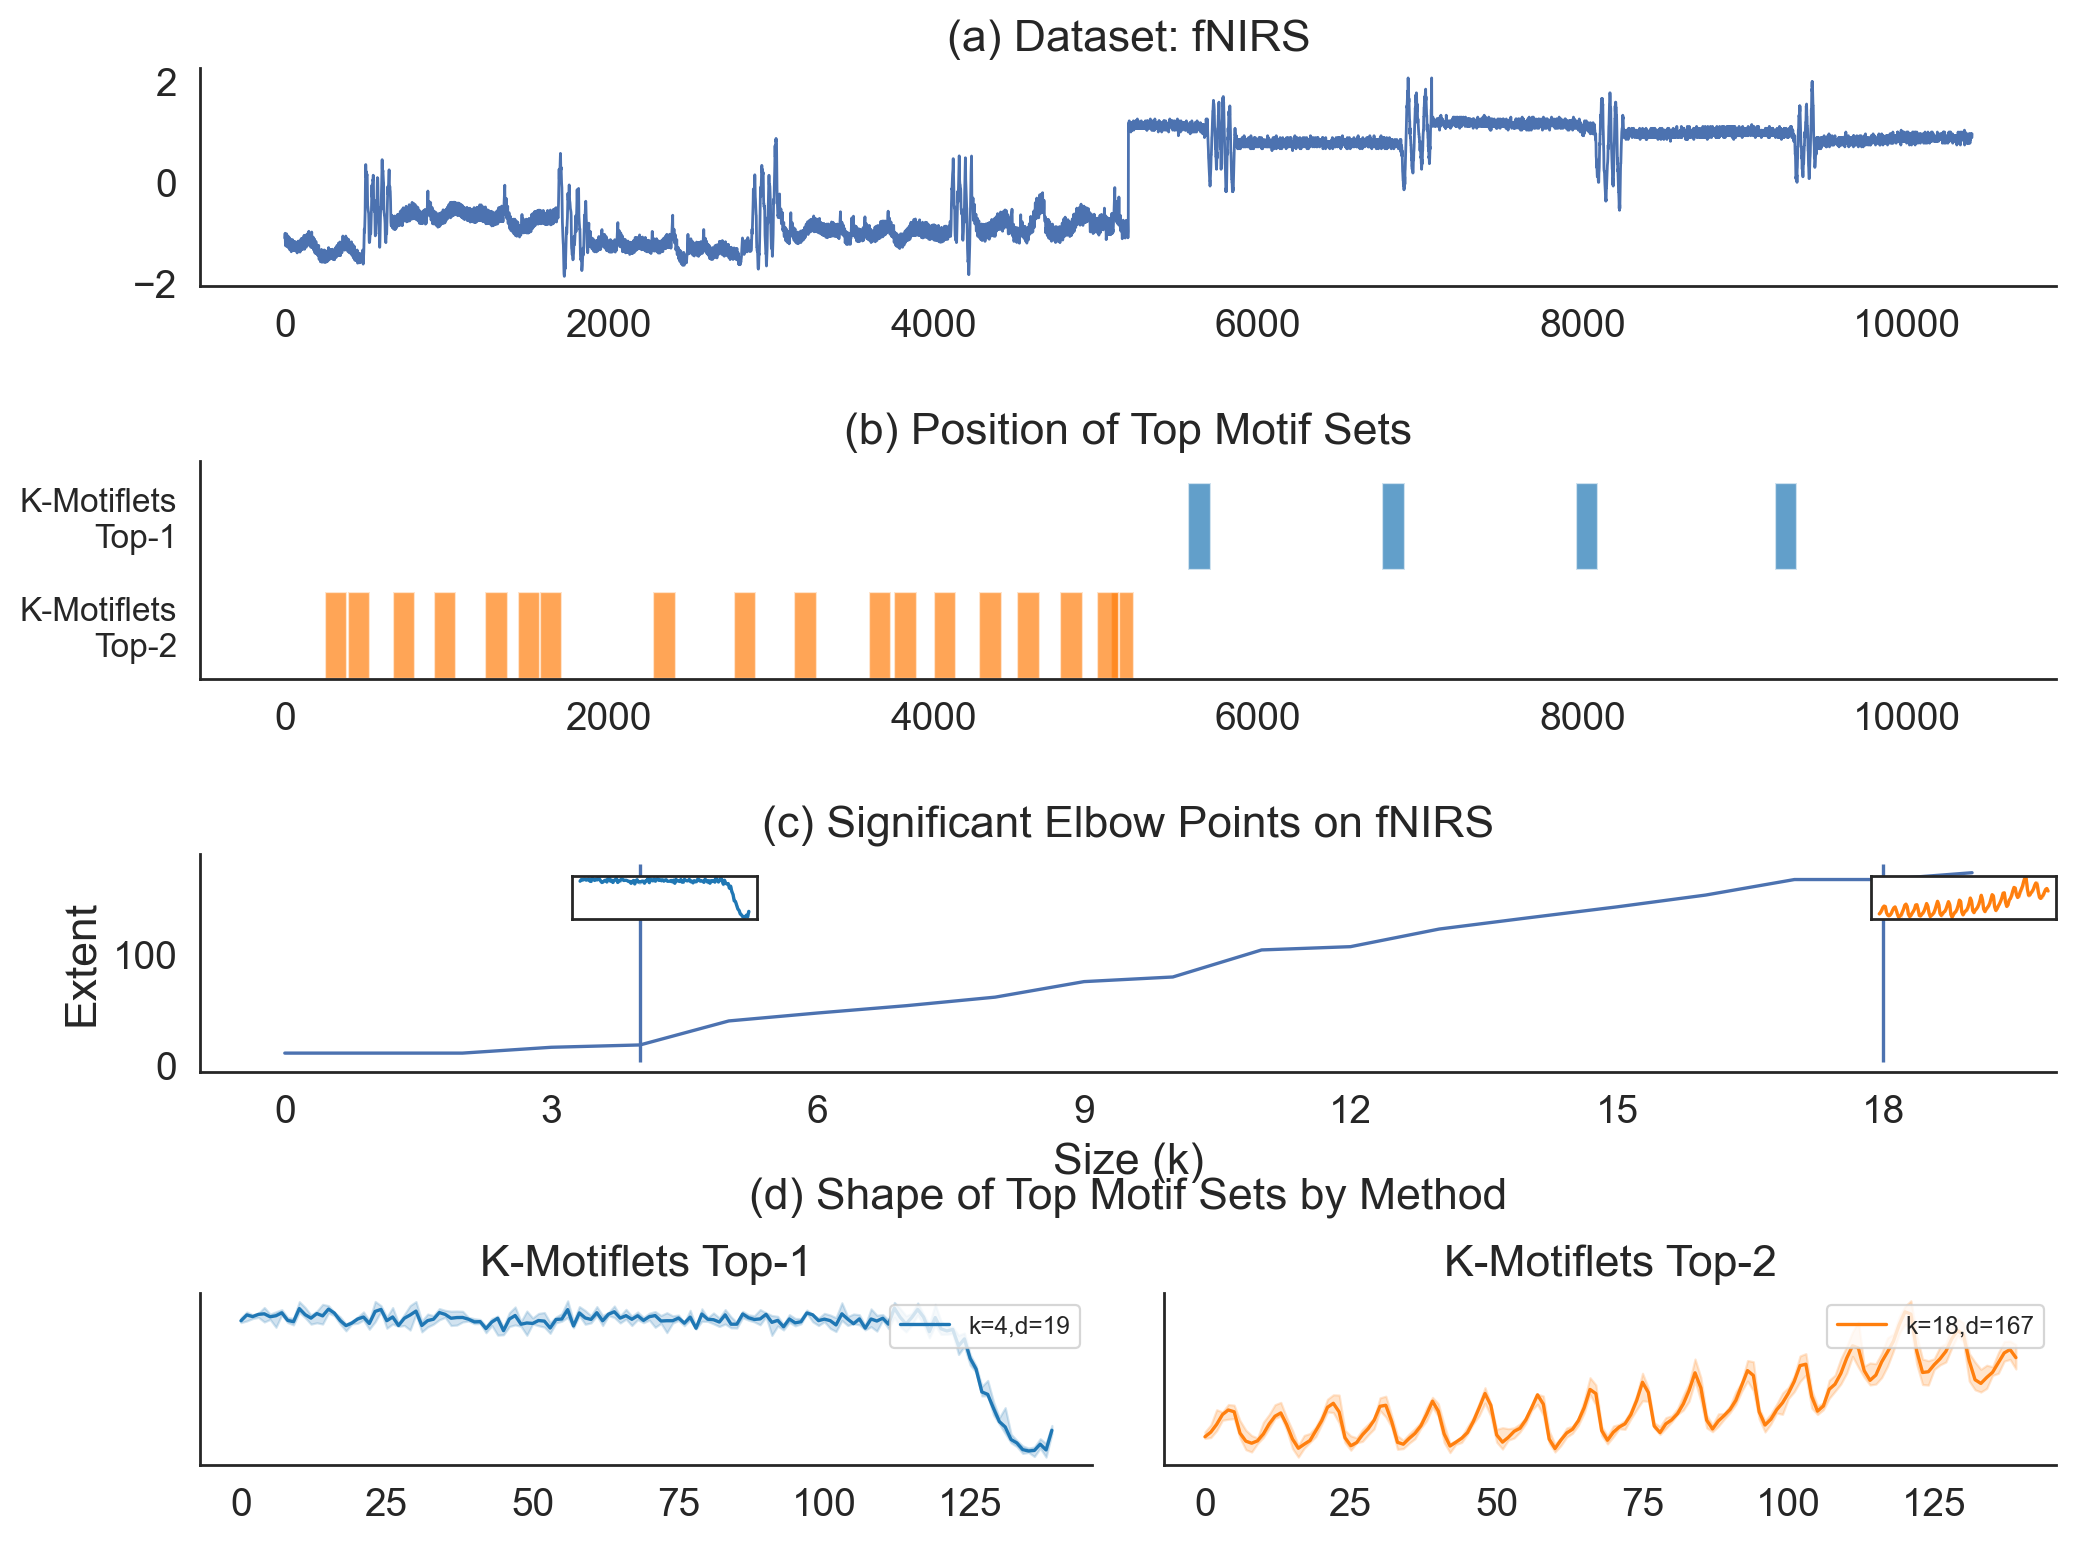

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, ds_name=ds_name, plot_elbows=True,
    motif_length=motif_length, method_name="K-Motiflets")

# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. We pretend to have an oracle on the length l and the radius r. 

In [6]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.array([r_top2, r_top1])
print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

Radius r of TOP-2 Motifs 92.94401550292969 16.95233726501465
Extent d of TOP-1 Motif 167.87452697753906
Best Radii	 [16.95233727 92.9440155 ]
Best Lengths	 140


# Competitors

We compare our $k$-Motiflets to the state-of-the-art motif set discovery methods. These are based on different definitions as follow:

<img src="images/motif_definitions.png"/>

# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [7]:
rs = np.array([r_top2*1.6, r_top1*0.9])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs+1)),
       str(mls)])

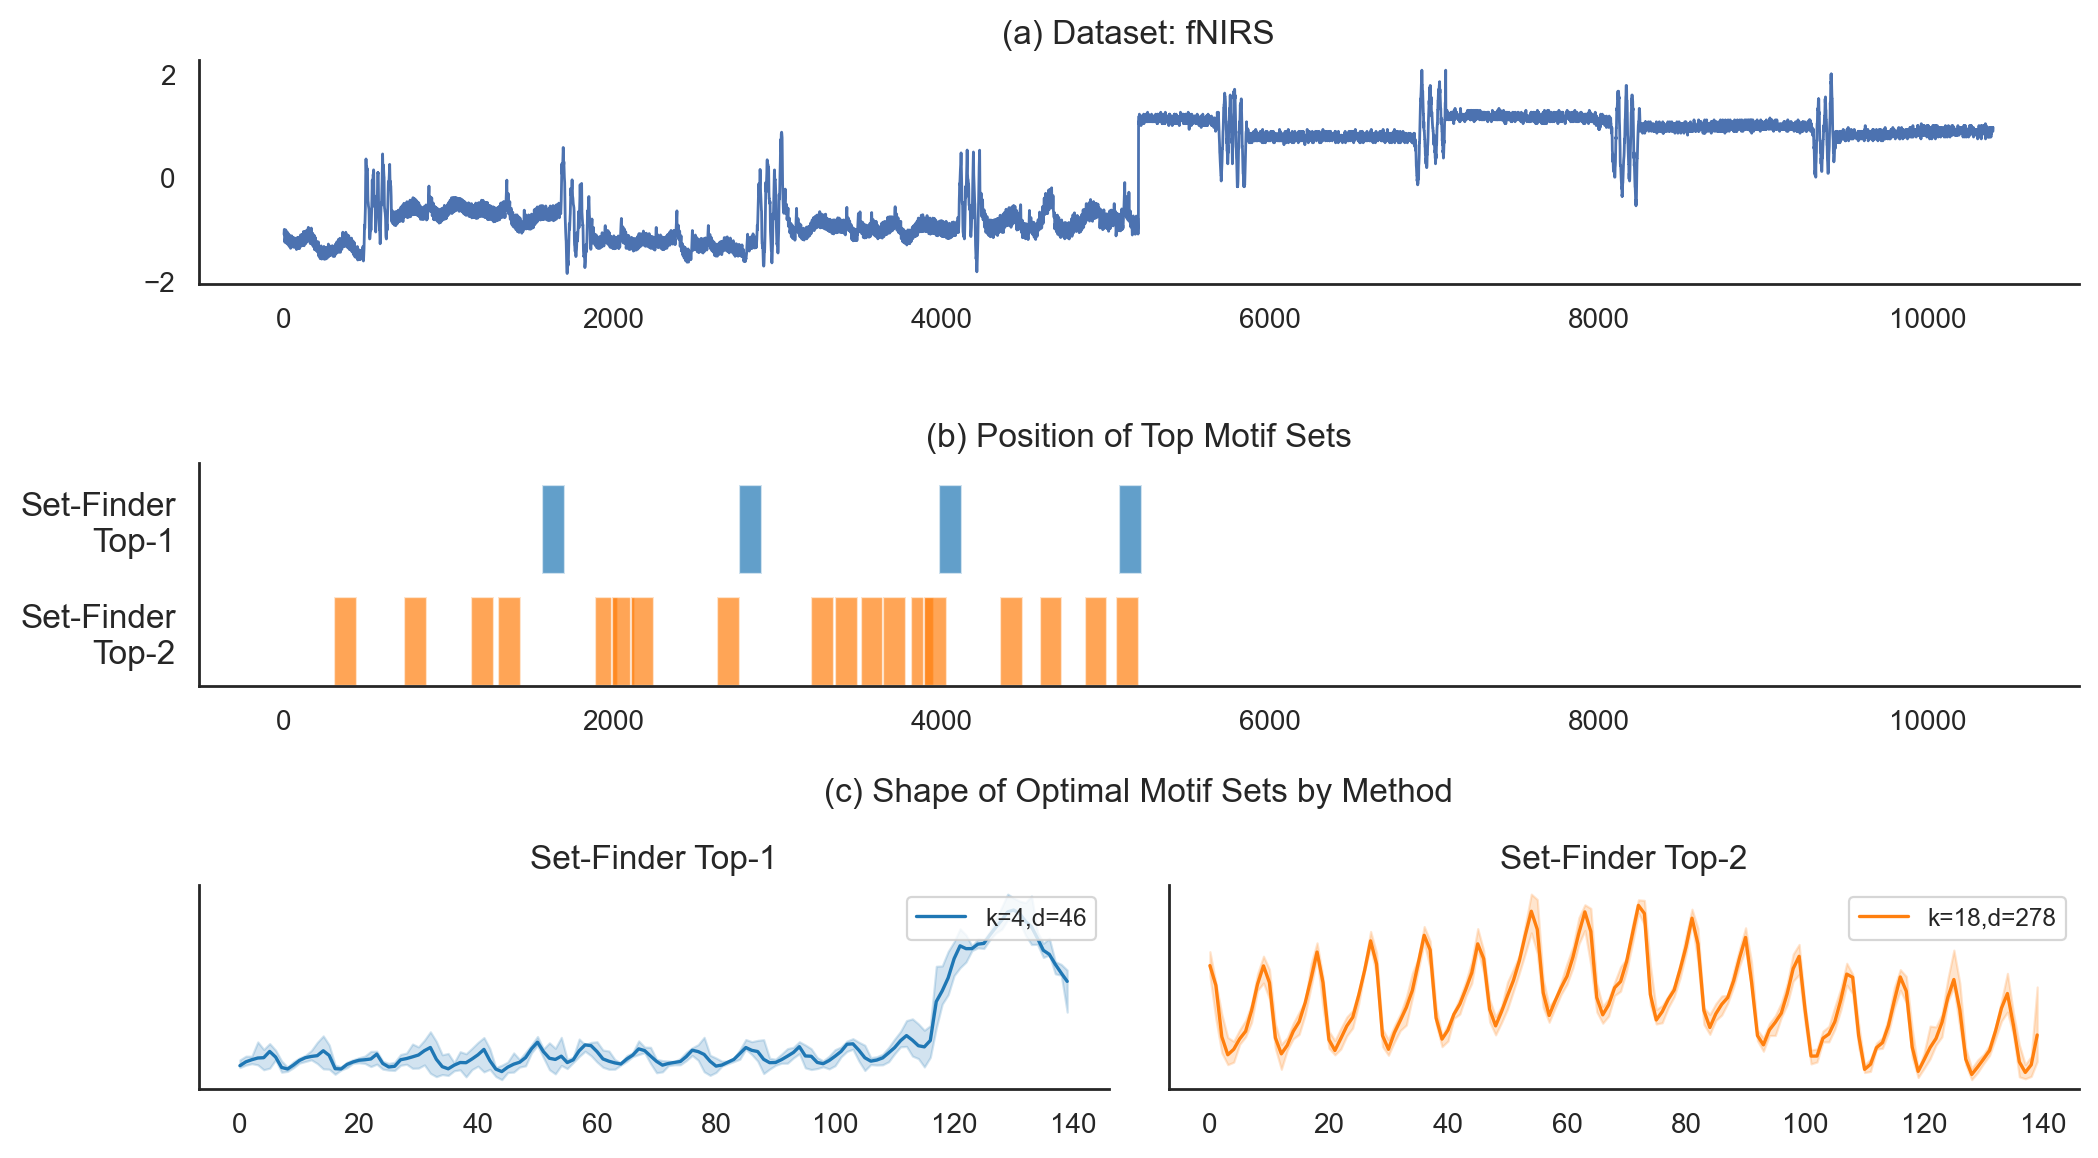

In [8]:
# run jave code first       
ms_set_finder = [
	[1570, 2767, 3988, 5083],
	[730, 304, 1139, 1301, 1891, 1998, 2114, 2634, 3206, 3352, 3513, 3646, 3814, 3894, 4358, 4598, 4872, 5061],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, 
                            filter=False, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]


# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [9]:
rs = np.array([r_top2*2.5, r_top1*1.39])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

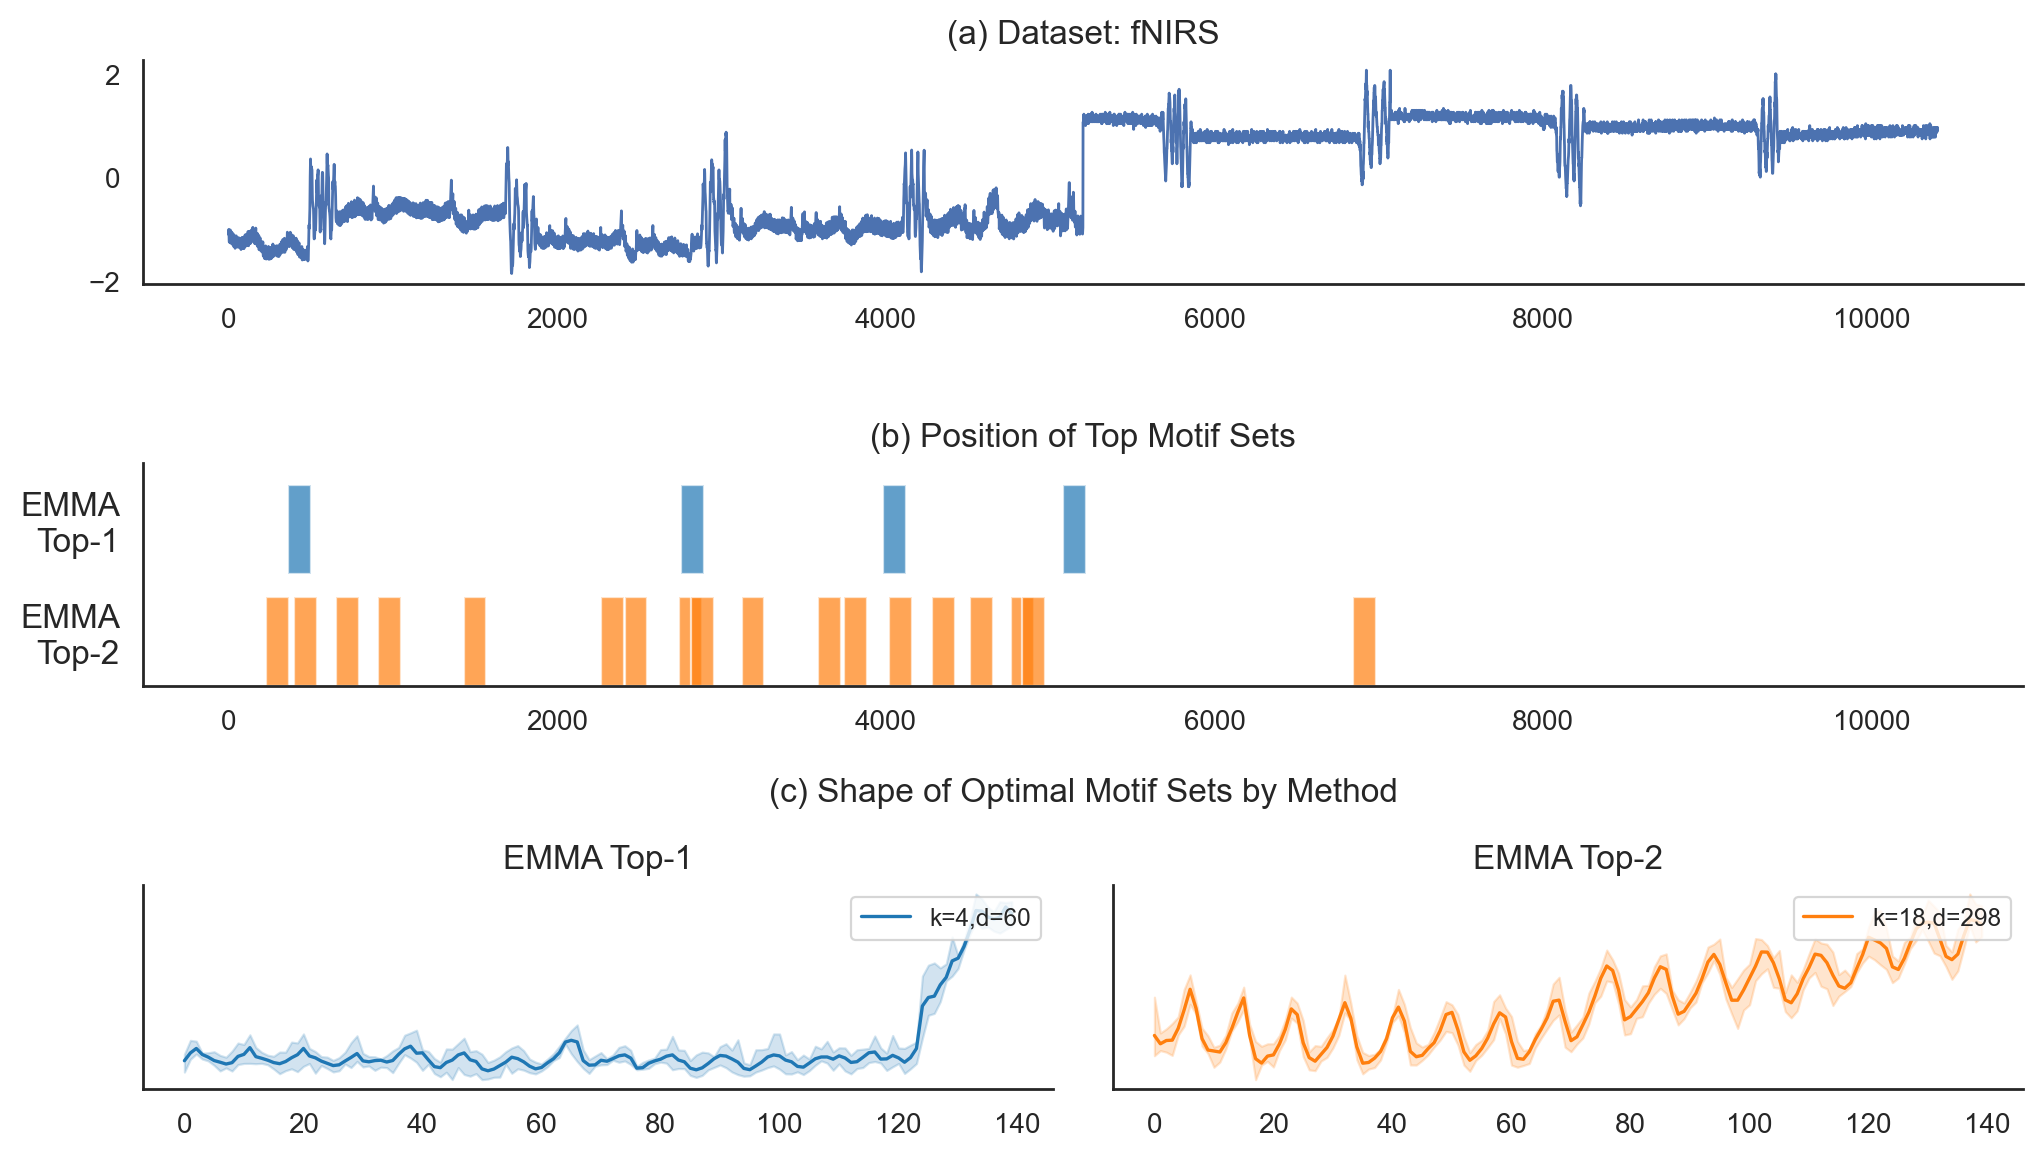

In [10]:
# run jave code first 
ms_emma=[
    [365, 2755, 3982, 5076],
	[228, 400, 653, 908, 1430, 2268, 2410, 2743, 2813, 3122, 3588, 3747, 4020, 4280, 4511, 4760, 4830, 6844]
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]

# Valmod Motif Sets
based on own (fixed-length) implementation

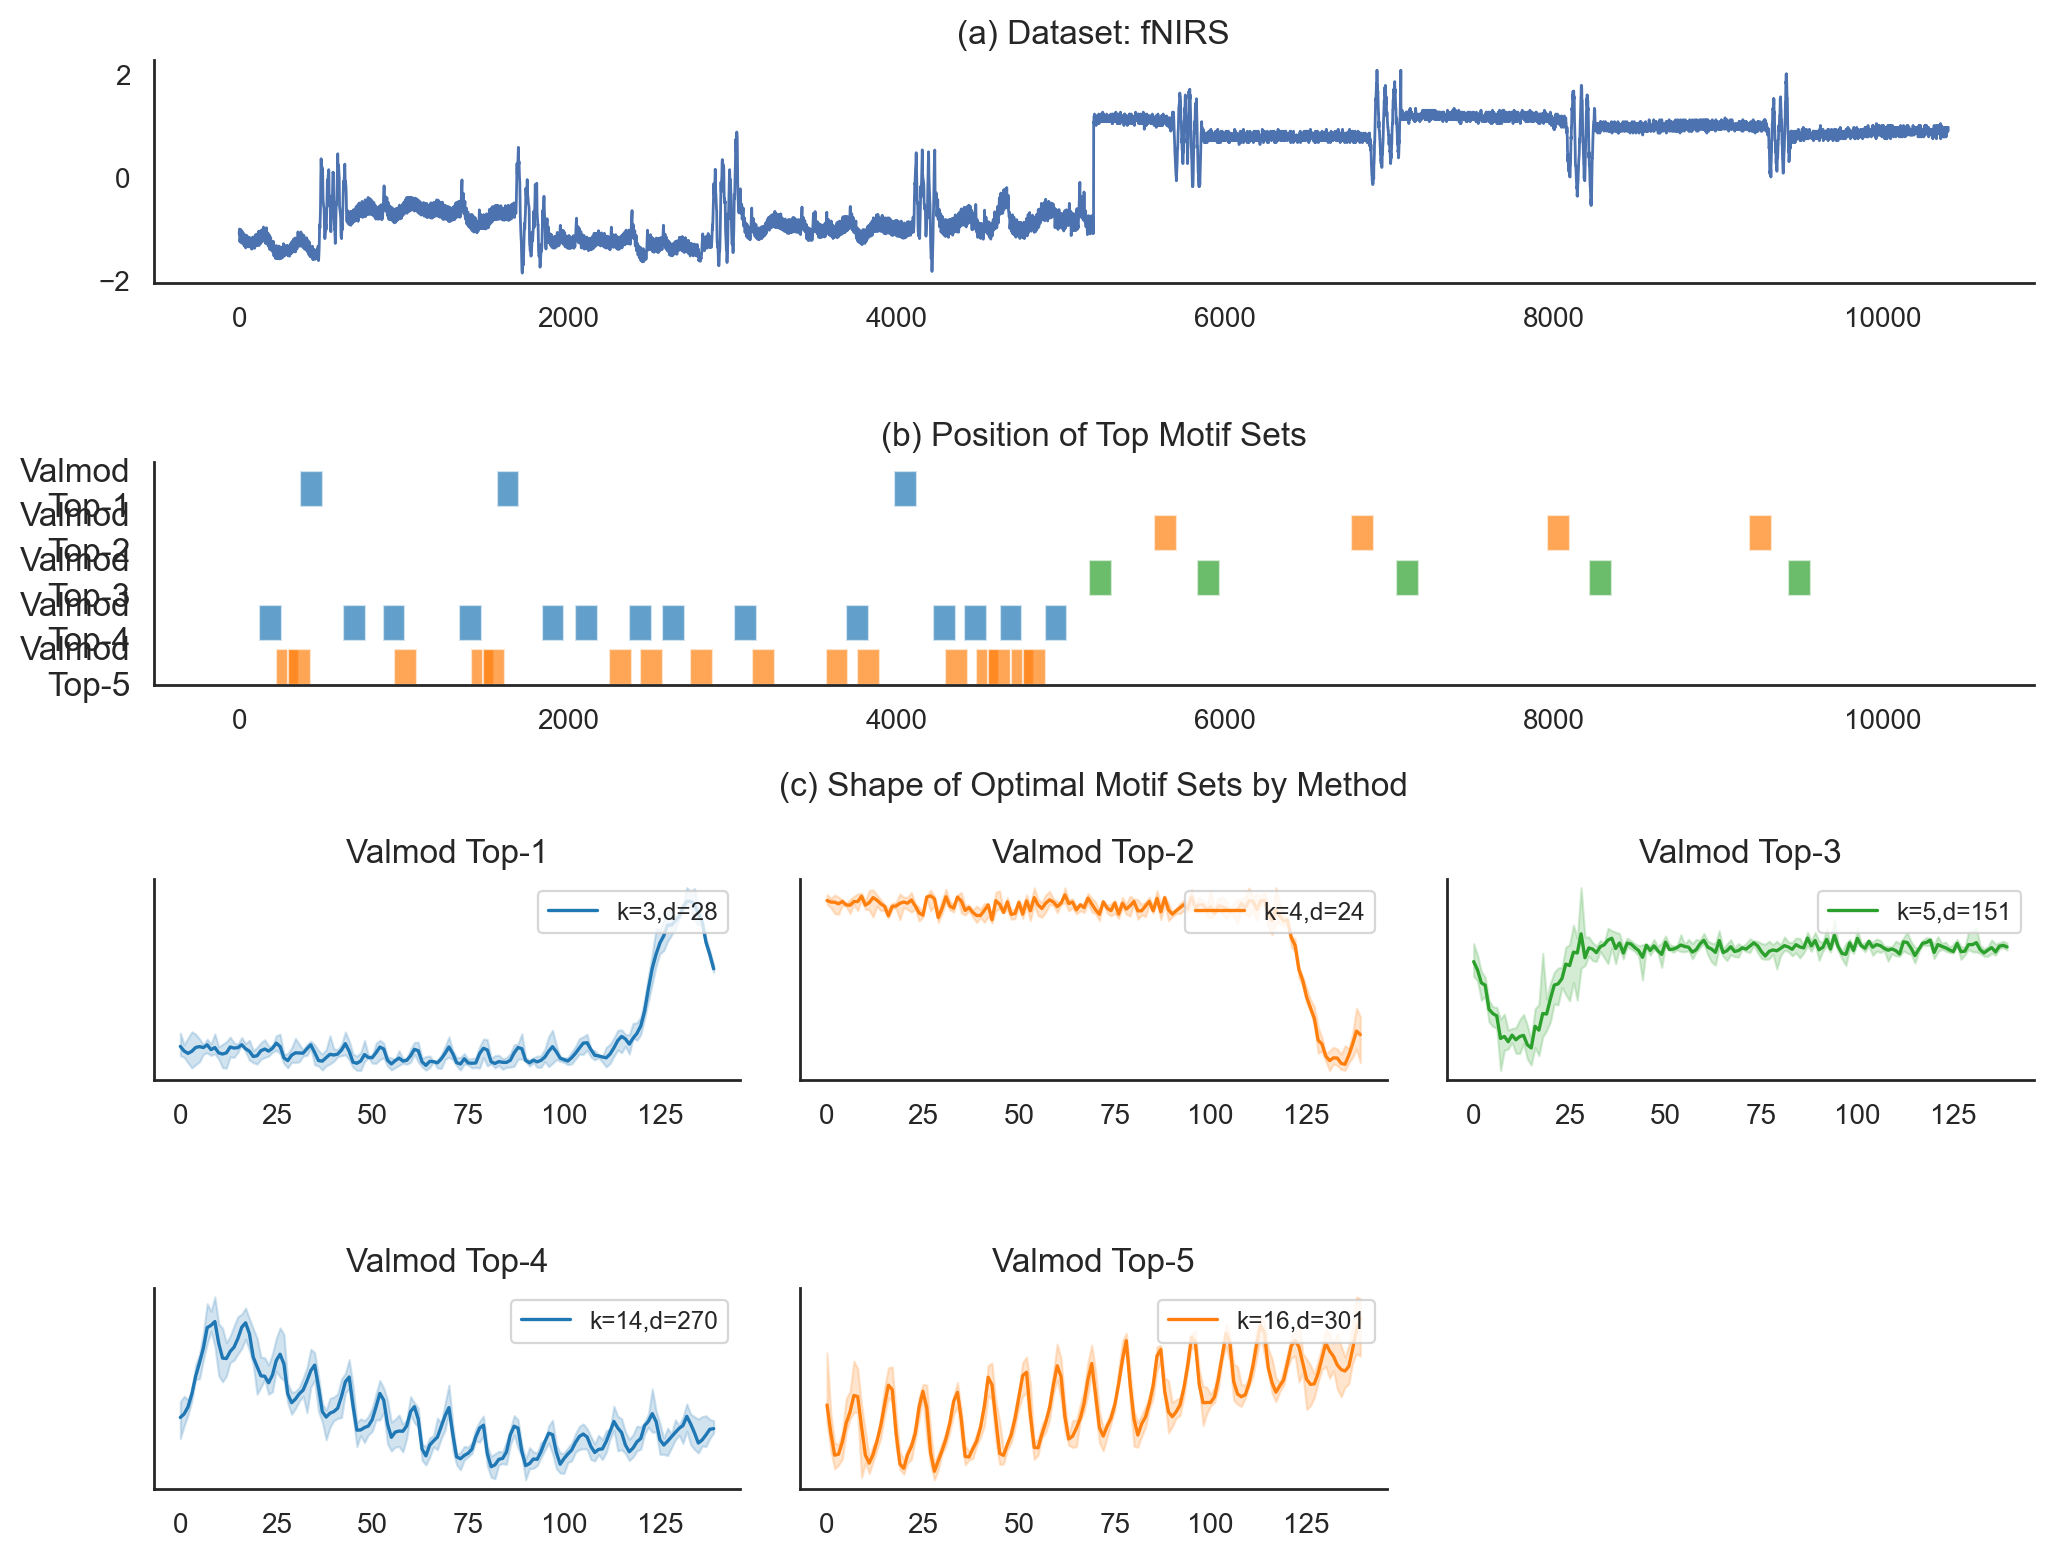

In [11]:
mls = motif_length
ms_valmod = list(get_valmod_motif_set_ranged(data, mls, max_r=r_top1*1.9))
motifset = plot_competitors(series, ds_name, ms_valmod, mls, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[0]]

# Learning Motifs
See Java Code

In [12]:
rs = np.array([r_top2*1.2, r_top1*1.0])
mls = motif_length

if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

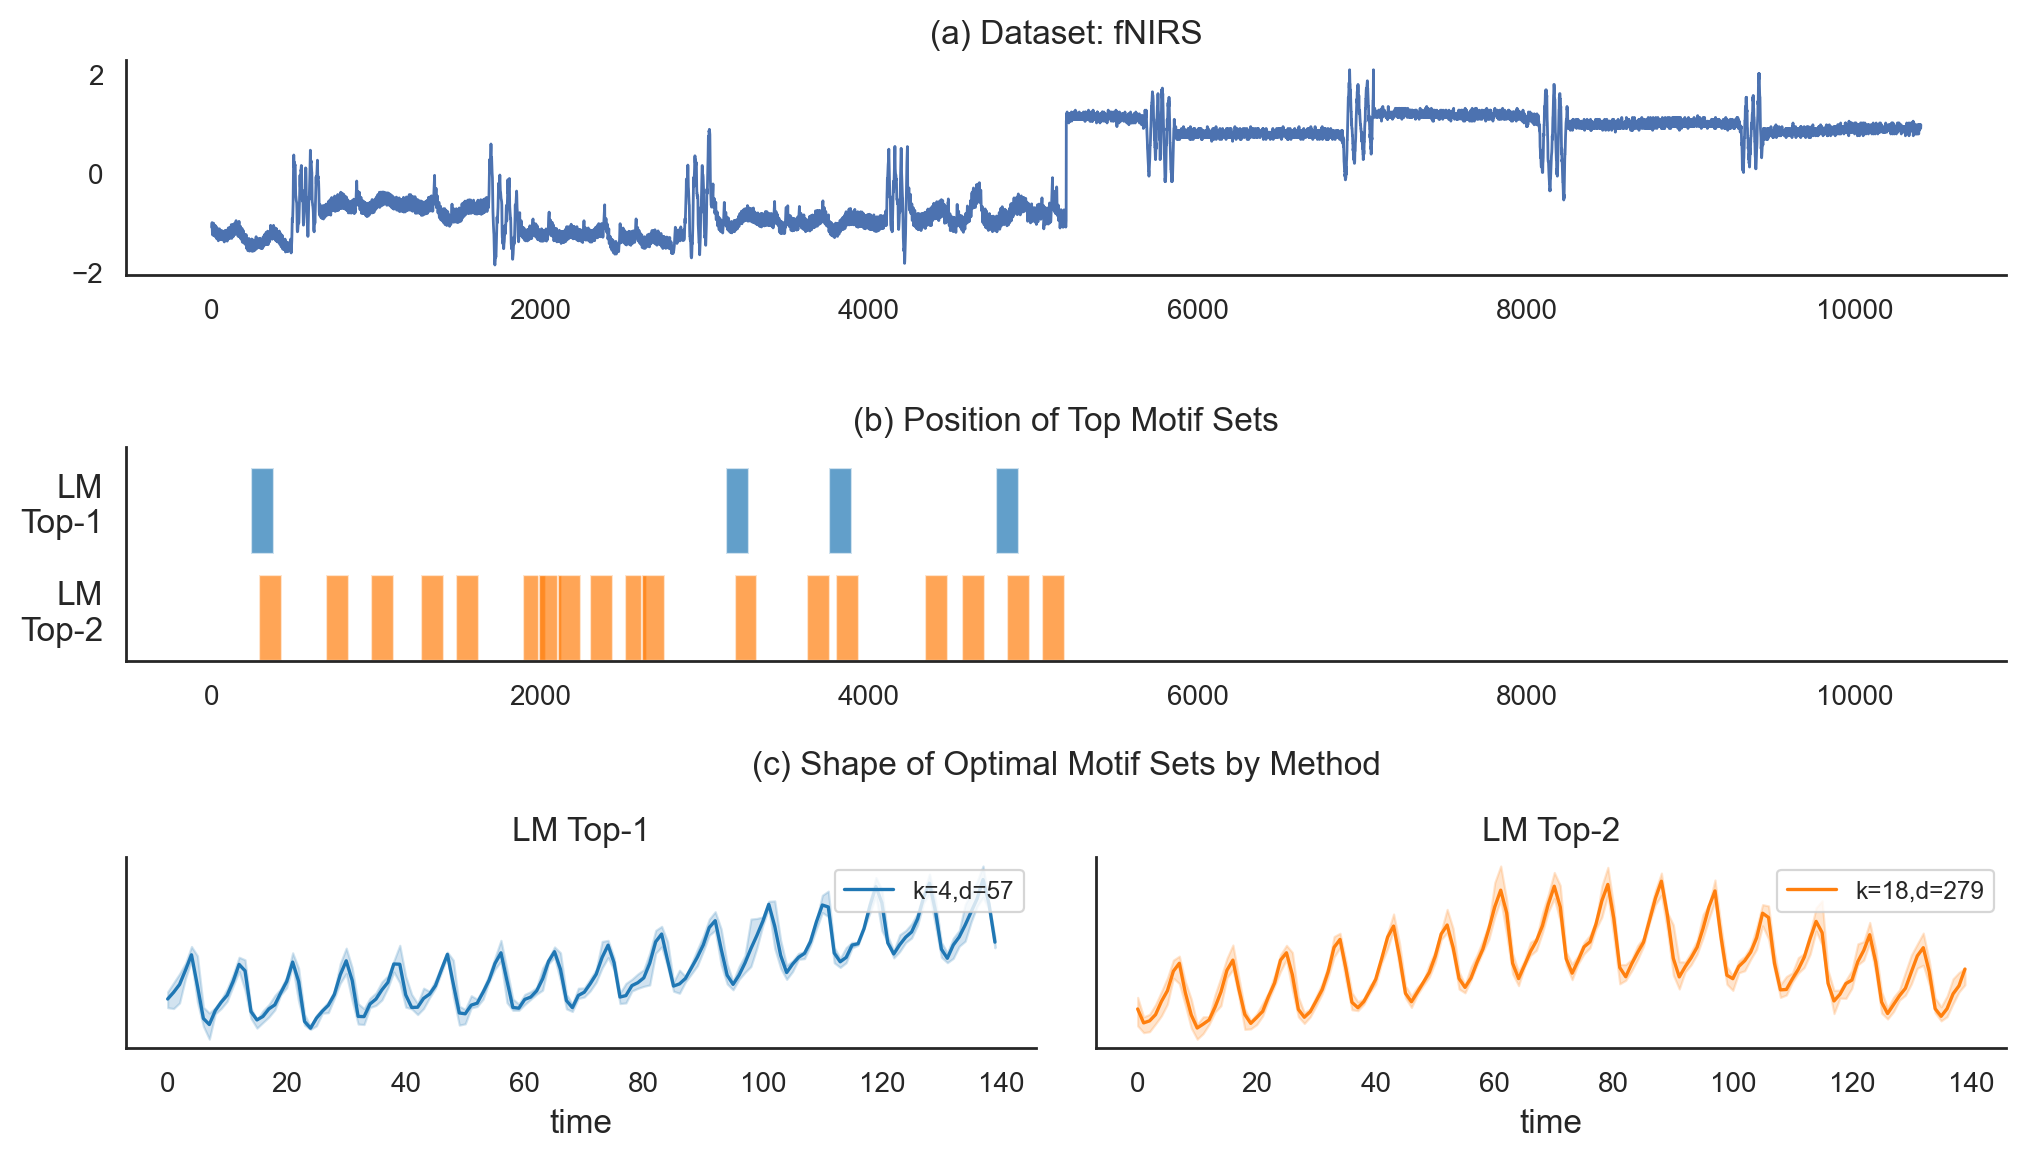

In [13]:
ms_learning_motifs = np.array([
	[239,3132,3758,4771,],
	[288,697,967,1276,1488,1893,1991,2108,2301,2512,2619,3181,3622,3798,4342,4565,4838,5054,],
])

    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df2["LM Top-2"] = [motifset[-2]]


# Comparison

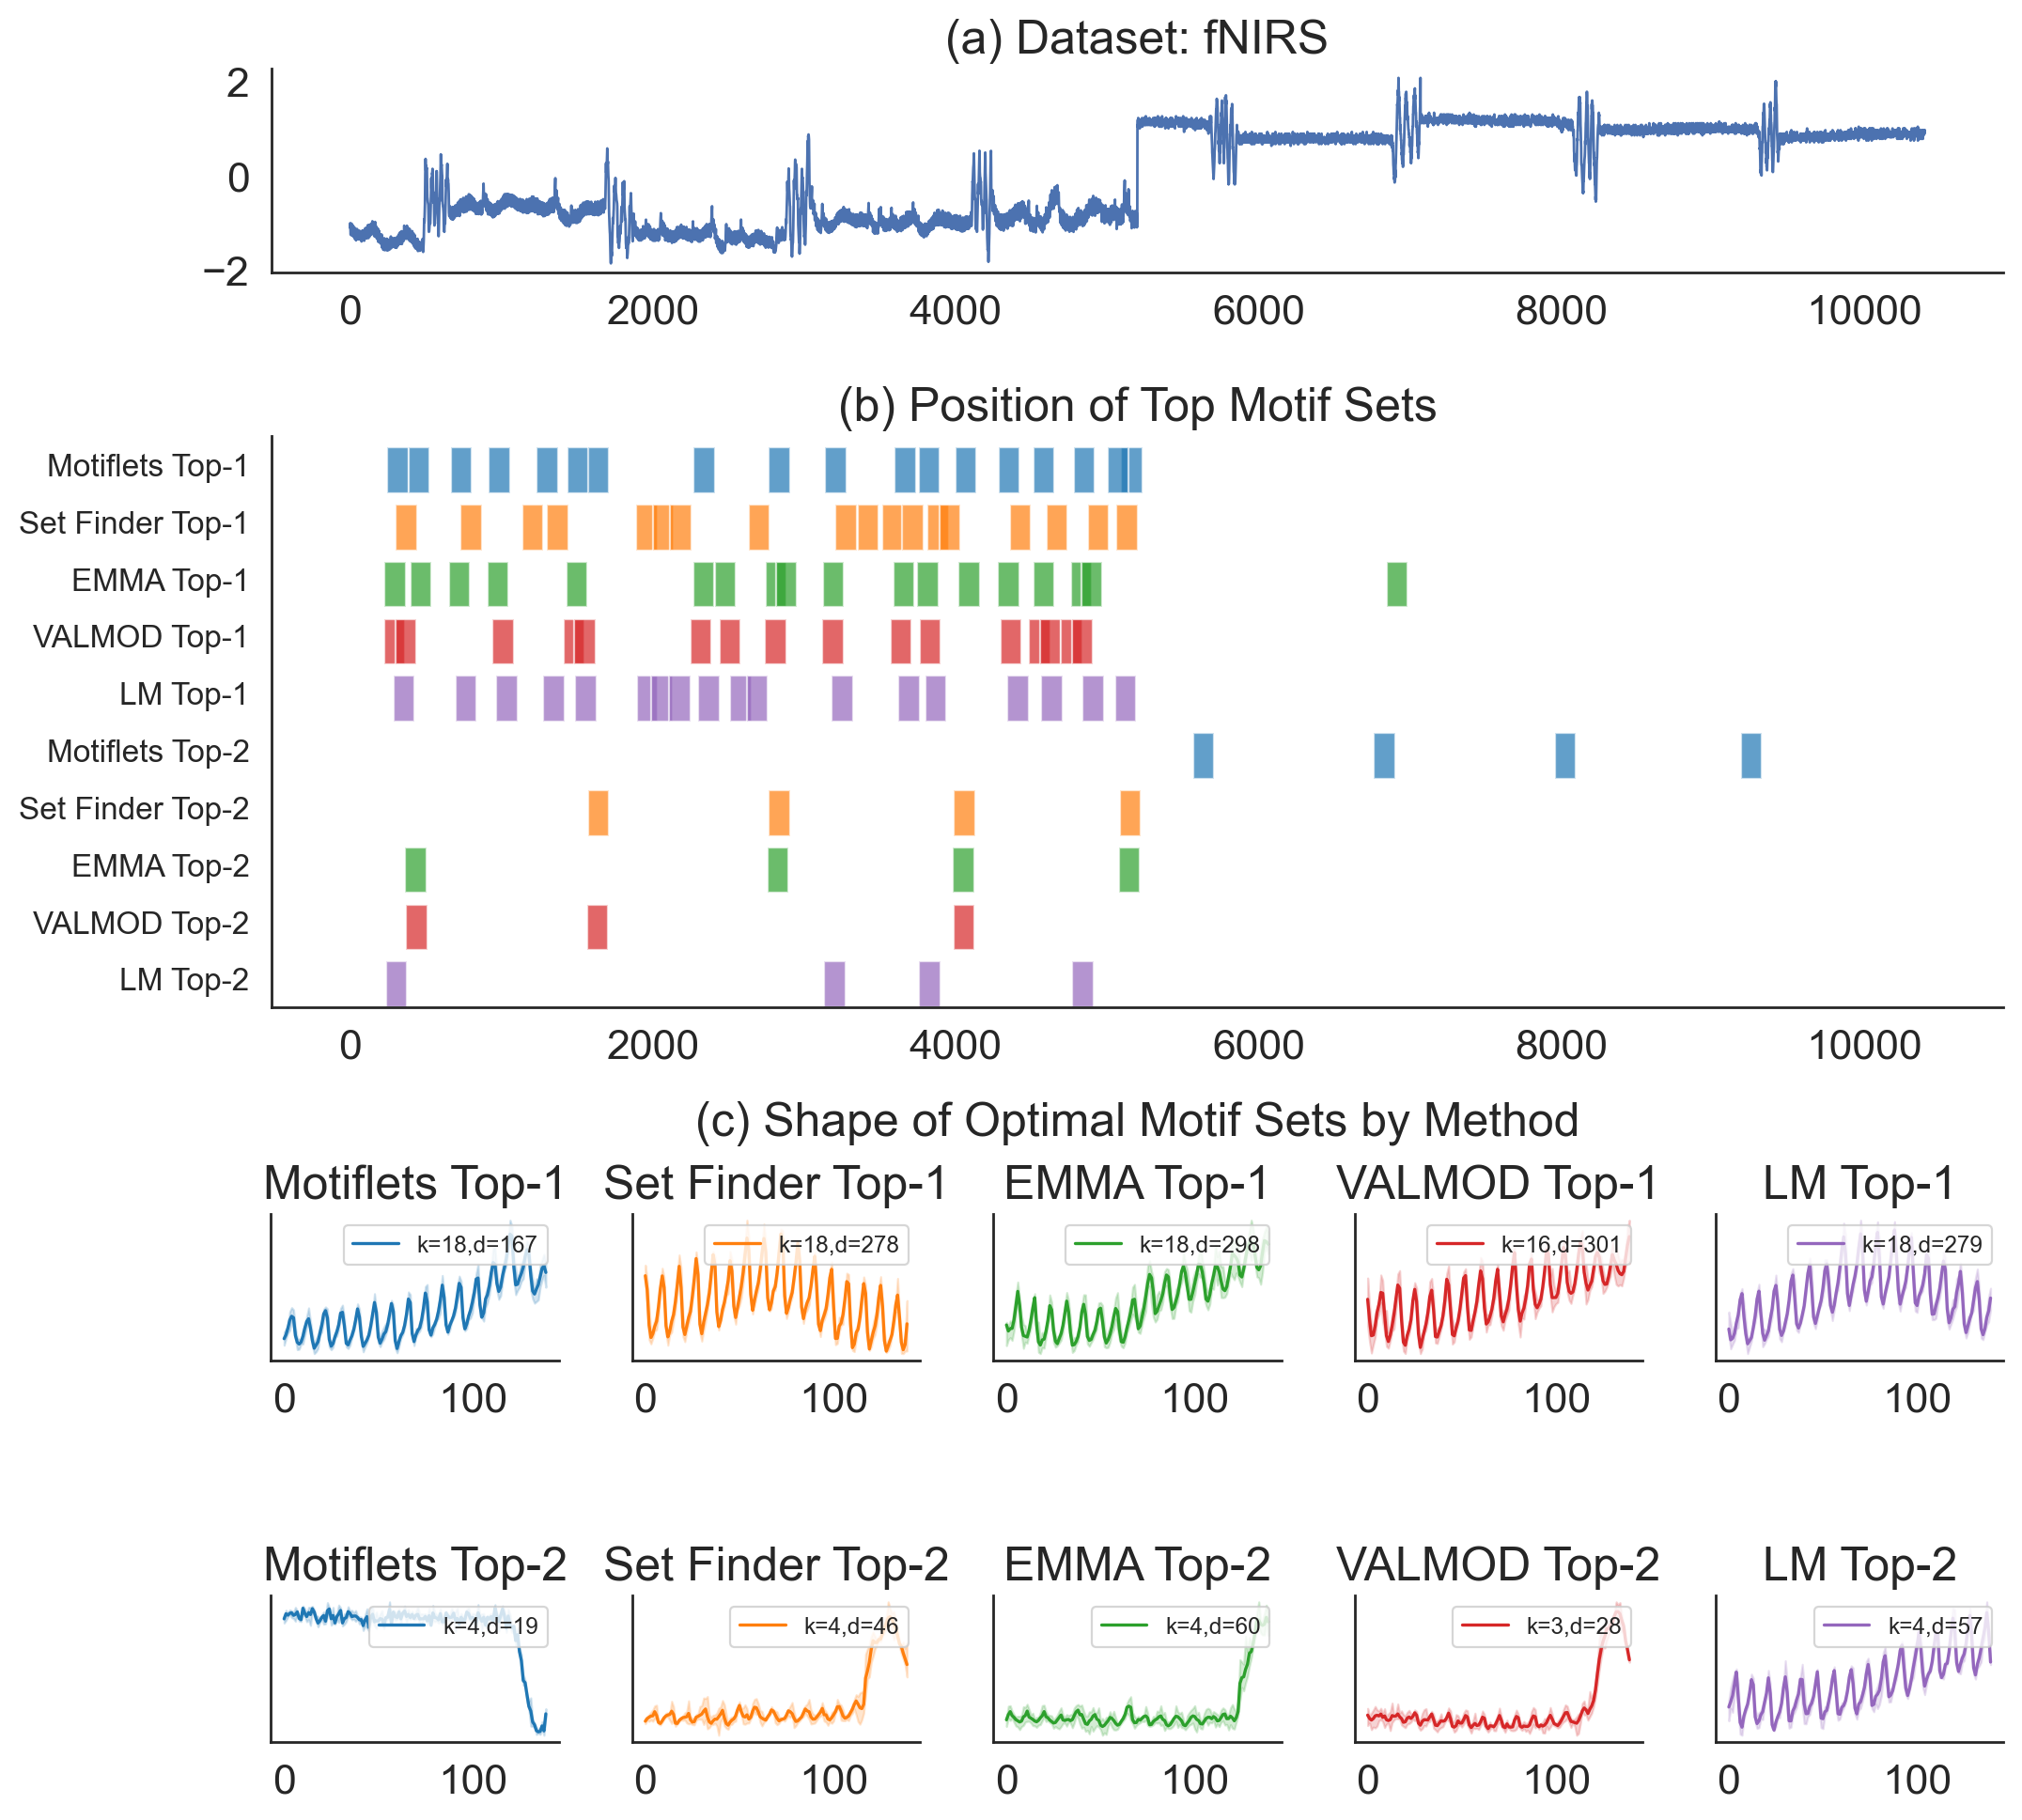

In [14]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values)